# Comparison and Validation of 3D Aerodynamics Methods

Here, we compare some of AeroSandbox's 3D aerodynamics analysis methods to those from other tools.

This study utilizes data courtesy of John Yost.

Consider the following swept flying-wing airplane:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

wing_airfoil = asb.Airfoil("sd7037")
tail_airfoil = asb.Airfoil("naca0010")

### Define the 3D geometry you want to analyze/optimize.
# Here, all distances are in meters and all angles are in degrees.
airplane = asb.Airplane(
    name="Peter's Glider",
    xyz_ref=[0, 0, 0],  # CG location
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,  # Should this wing be mirrored across the XZ plane?
            xsecs=[  # The wing's cross ("X") sections
                asb.WingXSec(  # Root
                    xyz_le=[0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    chord=0.18,
                    twist=2,  # degrees
                    airfoil=wing_airfoil,  # Airfoils are blended between a given XSec and the next one.
                ),
                asb.WingXSec(  # Mid
                    xyz_le=[0.01, 0.5, 0],
                    chord=0.16,
                    twist=0,
                    airfoil=wing_airfoil,
                ),
                asb.WingXSec(  # Tip
                    xyz_le=[0.08, 1, 0.1],
                    chord=0.08,
                    twist=-2,
                    airfoil=wing_airfoil,
                ),
            ]
        ),
        asb.Wing(
            name="Horizontal Stabilizer",
            symmetric=True,
            xsecs=[
                asb.WingXSec(  # root
                    xyz_le=[0, 0, 0],
                    chord=0.1,
                    twist=-10,
                    airfoil=tail_airfoil,
                ),
                asb.WingXSec(  # tip
                    xyz_le=[0.02, 0.17, 0],
                    chord=0.08,
                    twist=-10,
                    airfoil=tail_airfoil
                )
            ]
        ).translate([0.6, 0, 0.06]),
        asb.Wing(
            name="Vertical Stabilizer",
            symmetric=False,
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0, 0, 0],
                    chord=0.1,
                    twist=0,
                    airfoil=tail_airfoil,
                ),
                asb.WingXSec(
                    xyz_le=[0.04, 0, 0.15],
                    chord=0.06,
                    twist=0,
                    airfoil=tail_airfoil
                )
            ]
        ).translate([0.6, 0, 0.07])
    ],
    fuselages=[
        asb.Fuselage(
            name="Fuselage",
            xsecs=[
                asb.FuselageXSec(
                    xyz_c=[0.8 * xi - 0.1, 0, 0.1 * xi - 0.03],
                    radius=0.6 * asb.Airfoil("dae51").local_thickness(x_over_c=xi)
                )
                for xi in np.cosspace(0, 1, 30)
            ]
        )
    ]
)

Visualize it:

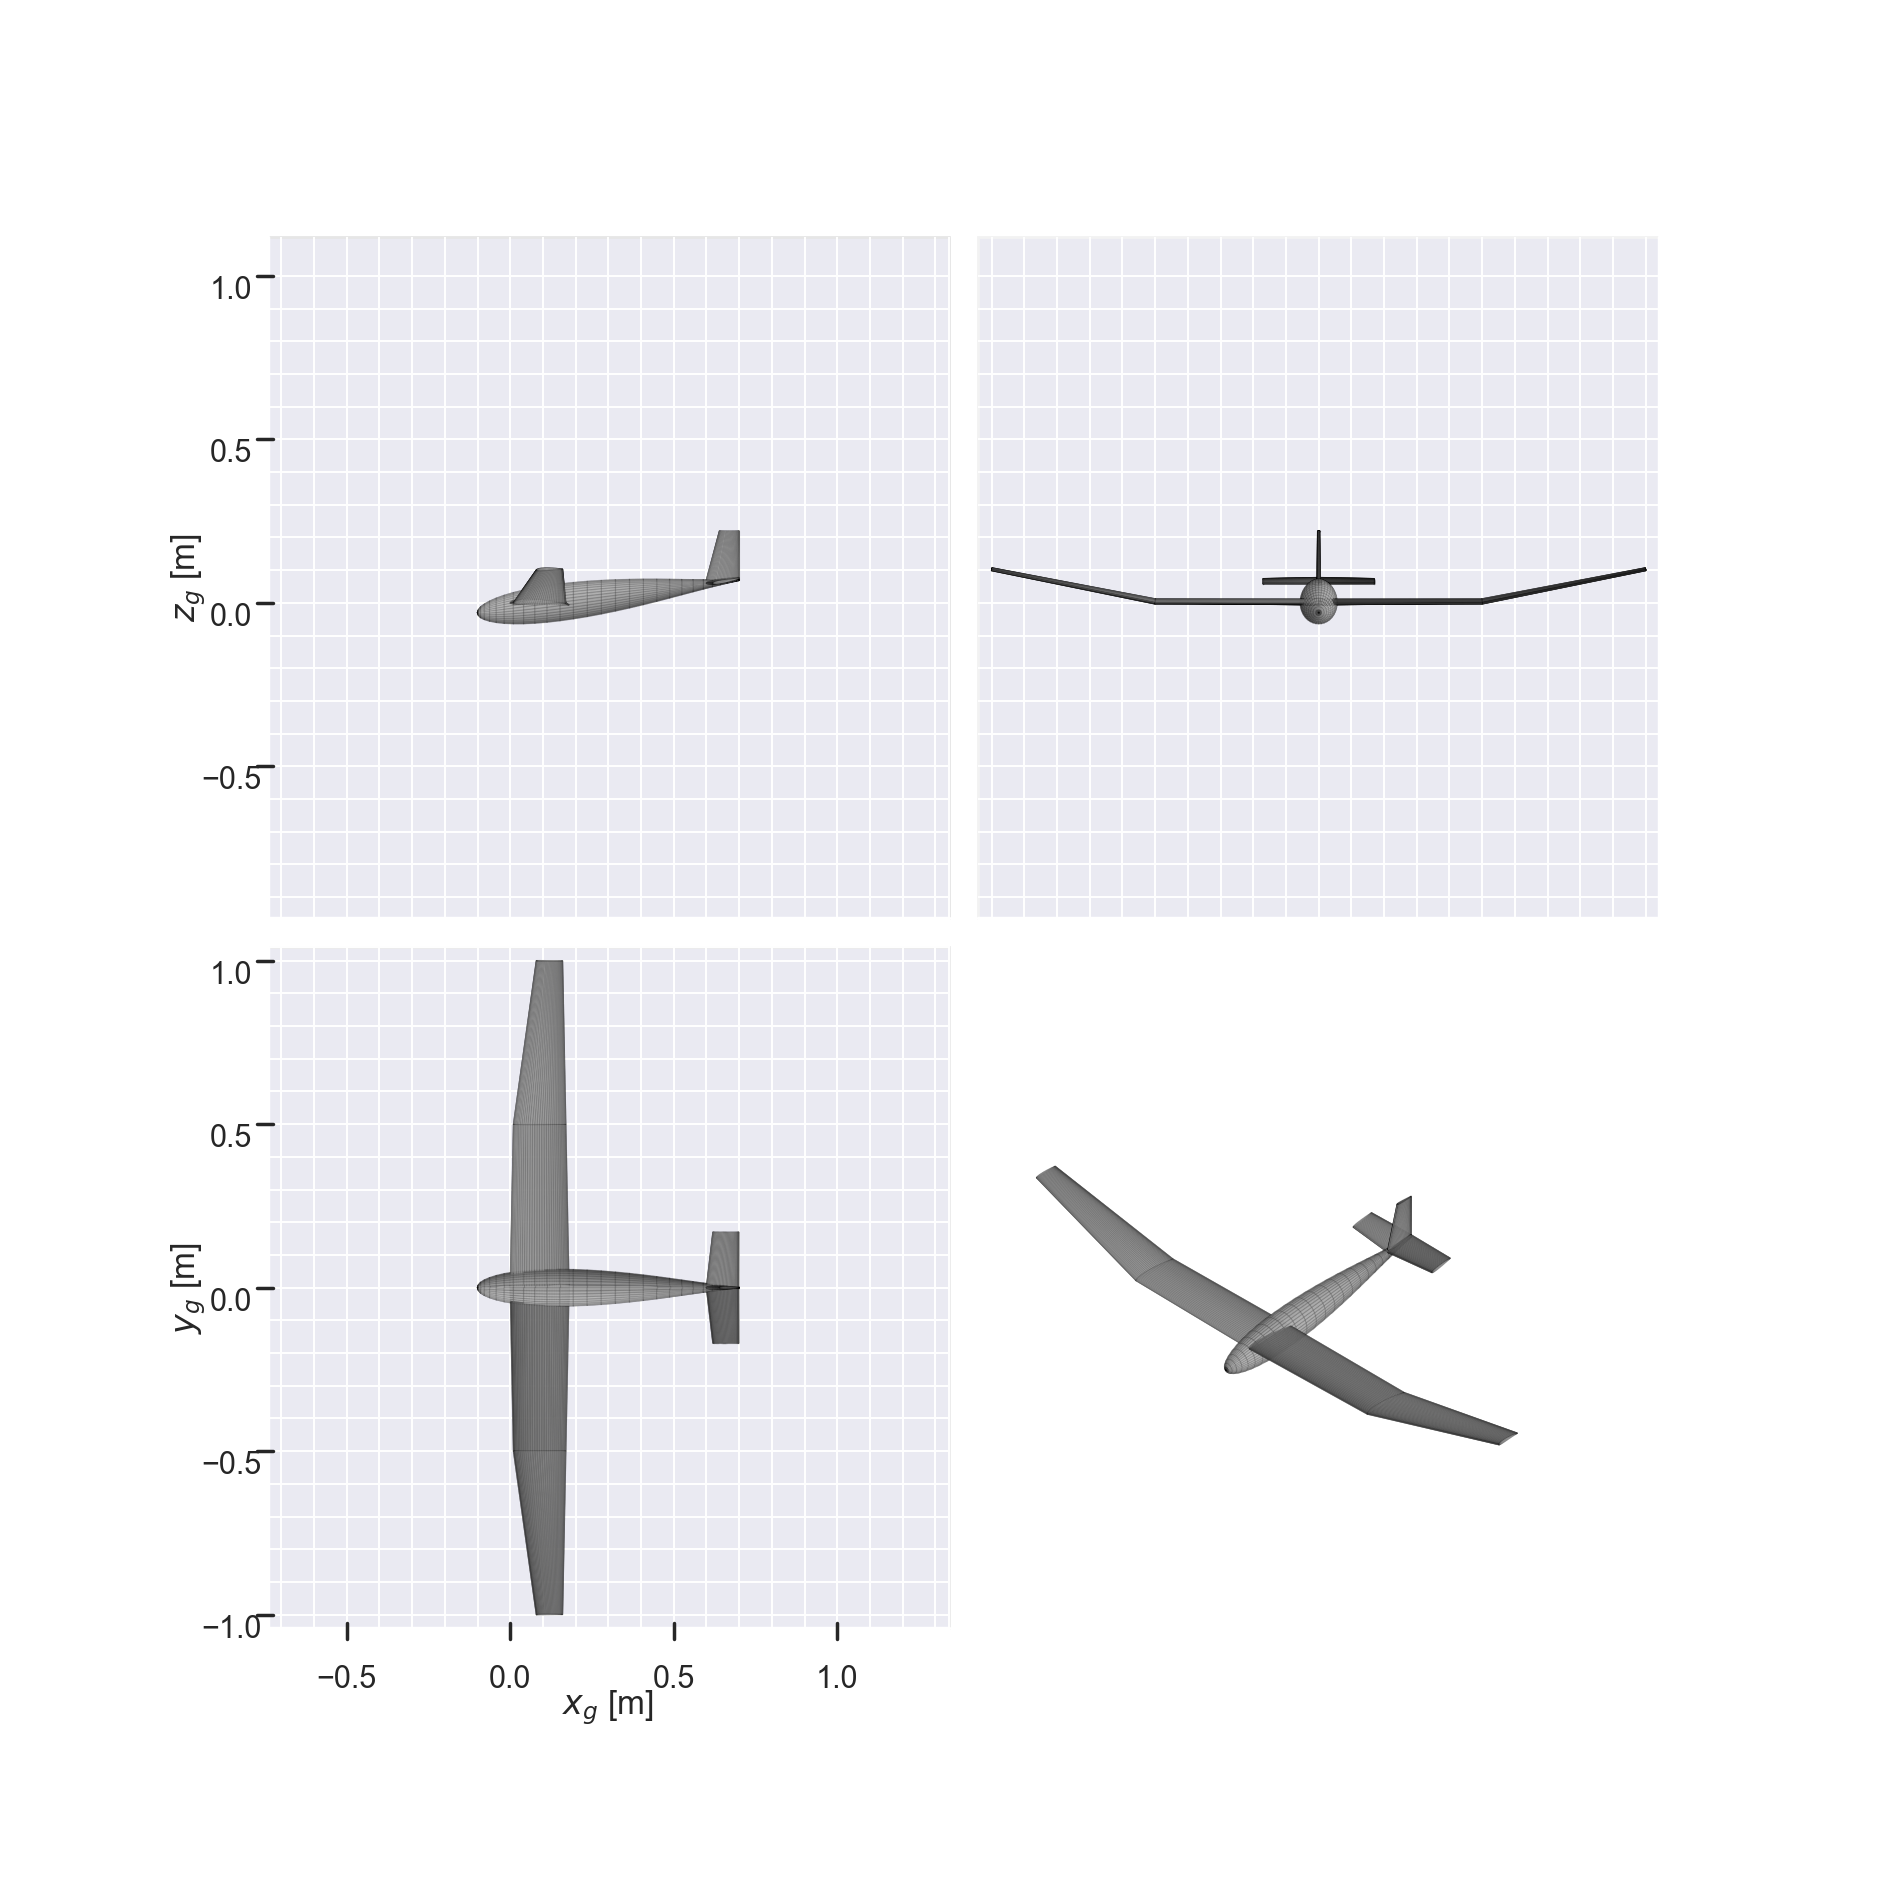

In [2]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

airplane.draw_three_view()

We wish to analyze it at the following aerodynamic operating point:

In [3]:
op_point = asb.OperatingPoint(
    atmosphere=asb.Atmosphere(altitude=0),
    velocity=91.3,  # m/s
)

xyz_ref = [
    airplane.wings[0].aerodynamic_center(chord_fraction=0.35)[0], 
    0, 
    0
]

while varying the angle of attack ($\alpha$).

## AeroBuildup Analysis

Analysis with AeroBuildup is simple, since it respects vectorization across operating points:

In [4]:
ab_op_point = op_point.copy()
ab_op_point.alpha = np.linspace(-12, 12, 50)

aerobuildup_aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=ab_op_point,
    xyz_ref=xyz_ref
).run()
aerobuildup_aero["alpha"] = ab_op_point.alpha

aerobuildup_aero

{'F_g': [array([  25.98848736,   12.10193454,   -2.4136209 ,  -16.24108404,
          -27.96919655,  -36.45836615,  -41.12844217,  -42.06500657,
          -39.92800348,  -35.67262616,  -30.1438926 ,  -23.79419133,
          -16.81969828,   -9.50562745,   -2.28877218,    4.41219021,
           10.29694691,   15.1726521 ,   18.94272942,   21.63292573,
           23.29686577,   23.89656122,   23.4542199 ,   22.10771484,
           19.93971225,   16.93520518,   13.04847915,    8.22181918,
            2.39853067,   -4.45512511,  -12.34370961,  -21.25634047,
          -31.18437613,  -42.12557257,  -54.06930911,  -66.97924021,
          -80.79857153,  -95.47533676, -110.97417193, -127.25942633,
         -144.27722374, -161.95665756, -180.22486226, -199.01924953,
         -218.28300186, -237.9541024 , -257.95652454, -278.19622119,
         -298.5598961 , -318.916025  ]),
  array([1.99017124e-14, 1.99018088e-14, 1.99017991e-14, 1.99016834e-14,
         1.99014617e-14, 1.99011340e-14, 1.99007006

## VortexLatticeMethod Analysis

Analysis with `asb.VortexLatticeMethod` is a smidge more work, since it isn't written in a way that allows vectorization across operating points (so, we have to iterate manually if we want to do an $\alpha$ sweep):

In [5]:
vlm_op_point = op_point.copy()
vlm_op_point.alpha = np.linspace(-12, 12, 13)

vlm_aeros = [
    asb.VortexLatticeMethod(
        airplane=airplane,
        op_point=op,
        xyz_ref=xyz_ref,
        spanwise_resolution=5
    ).run()
    for op in vlm_op_point
]

vlm_aero = {}

for k in vlm_aeros[0].keys():
    vlm_aero[k] = np.array([
        aero[k]
        for aero in vlm_aeros
    ])
vlm_aero["alpha"] = vlm_op_point.alpha

vlm_aero

{'F_g': array([[-2.49248160e+02,  6.59766815e-15, -1.40321775e+03],
        [-1.63049285e+02,  4.75074837e-15, -1.12778317e+03],
        [-9.38103973e+01, -5.04210860e-14, -8.45617258e+02],
        [-4.18688209e+01, -3.21752397e-15, -5.58094715e+02],
        [-7.47761029e+00, -1.54219773e-14, -2.66616318e+02],
        [ 9.19568409e+00,  4.14418782e-15,  2.73978806e+01],
        [ 8.06983161e+00,  9.77679003e-15,  3.22515473e+02],
        [-1.08496827e+01, -1.54016664e-14,  6.17298675e+02],
        [-4.74706848e+01,  2.28659479e-14,  9.10311333e+02],
        [-1.01614761e+02, -8.63841138e-16,  1.20012592e+03],
        [-1.73018127e+02,  3.98757342e-15,  1.48533049e+03],
        [-2.61332912e+02, -2.93892730e-15,  1.76453555e+03],
        [-3.66128856e+02,  4.71262624e-14,  2.03638084e+03]]),
 'F_b': array([[ 2.49248160e+02,  6.59766815e-15,  1.40321775e+03],
        [ 1.63049285e+02,  4.75074837e-15,  1.12778317e+03],
        [ 9.38103973e+01, -5.04210860e-14,  8.45617258e+02],
        

## Nonlinear Lifting Line Analysis

Similarly, `asb.NonlinearLiftingLine` doesn't allow vectorization across operating points:

In [6]:
# nlll_op_point = op_point.copy()
# nlll_op_point.alpha = np.linspace(-3, 3, 5)
# 
# nlll_aeros = [
#     asb.NonlinearLiftingLine(
#         airplane=airplane,
#         op_point=op,
#         xyz_ref=xyz_ref,
#     ).run()
#     for op in nlll_op_point
# ]
# 
# nlll_aero = {}
# for k in nlll_aeros[0].keys():
#     nlll_aero[k] = np.array([
#         aero[k]
#         for aero in nlll_aeros
#     ])
# nlll_aero["alpha"] = nlll_op_point.alpha
# 
# nlll_aero

## (Quasi-Linear) Lifting Line Analysis

In [7]:
ll_op_point = op_point.copy()
ll_op_point.alpha = np.linspace(-12, 14, 15)

ll_aeros = [
    asb.LiftingLine(
        airplane=airplane,
        op_point=op,
        xyz_ref=xyz_ref,
    ).run()
    for op in ll_op_point
]

ll_aero = {}
for k in ll_aeros[0].keys():
    ll_aero[k] = np.array([
        aero[k]
        for aero in ll_aeros
    ])
ll_aero["alpha"] = ll_op_point.alpha

ll_aero

{'F_g': array([[ 9.89286327e+01, -4.30217753e-15, -6.72612234e+02],
        [ 4.71969541e+01, -1.87604079e-14, -6.67728736e+02],
        [ 7.21164620e+00, -2.62183001e-14, -6.34521547e+02],
        [-4.25342164e-03, -1.73370647e-14, -4.78152367e+02],
        [ 1.16164608e+01, -1.21208872e-14, -2.48236137e+02],
        [ 2.66058369e+01, -1.24456945e-14, -1.68181949e-01],
        [ 2.88708155e+01, -2.01381581e-14,  2.59224966e+02],
        [ 1.63036689e+01, -1.12615683e-14,  5.41436770e+02],
        [-1.01780940e+01, -3.47758882e-15,  8.34086668e+02],
        [-5.08861990e+01, -1.52201701e-14,  1.10558387e+03],
        [-1.04591968e+02, -6.38328211e-15,  1.35222101e+03],
        [-1.67655027e+02, -1.98048649e-14,  1.56376493e+03],
        [-2.33932019e+02, -4.52997145e-16,  1.71864500e+03],
        [-2.97295426e+02, -2.92594988e-14,  1.80937719e+03],
        [-3.48494815e+02, -2.24481888e-14,  1.83035067e+03]]),
 'M_g': array([[-5.28832732e-14,  2.24630368e+01,  1.10311207e-14],
        

## AVL (External) Analysis

In [8]:
# avl_aeros = [
#     asb.AVL(
#         airplane=airplane,
#         op_point=op,
#         xyz_ref=xyz_ref,
#         working_directory=Path.home() / "Downloads" / "test",
#         verbose=True
#     ).run()
#     for op in op_point
# ]
#
# avl_aero = {}
#
# for k in vlm_aeros[0].keys():
#     avl_aero[k] = np.array([
#         aero[k]
#         for aero in avl_aeros
#     ])
#
# avl_aero

## Comparison and Validation

In [9]:
# name_data_paths = {
#     # "AVL 3.35 (inviscid)"   : assets / "avl.csv",
#     "AVL + Quadratic-Fit XFoil"            : assets / "avl_and_xfoil.csv",
#     "Panel + IBL": assets / "panel_and_IBL.csv",
#     "OpenVSP 3.31.1 Panel + Skin Friction" : assets / "openvsp_panel.csv",
# }
# 
# import pandas as pd
# 
# name_data = {
#     k: pd.read_csv(
#         v,
# 
#     )
#     for k, v in name_data_paths.items()
# }

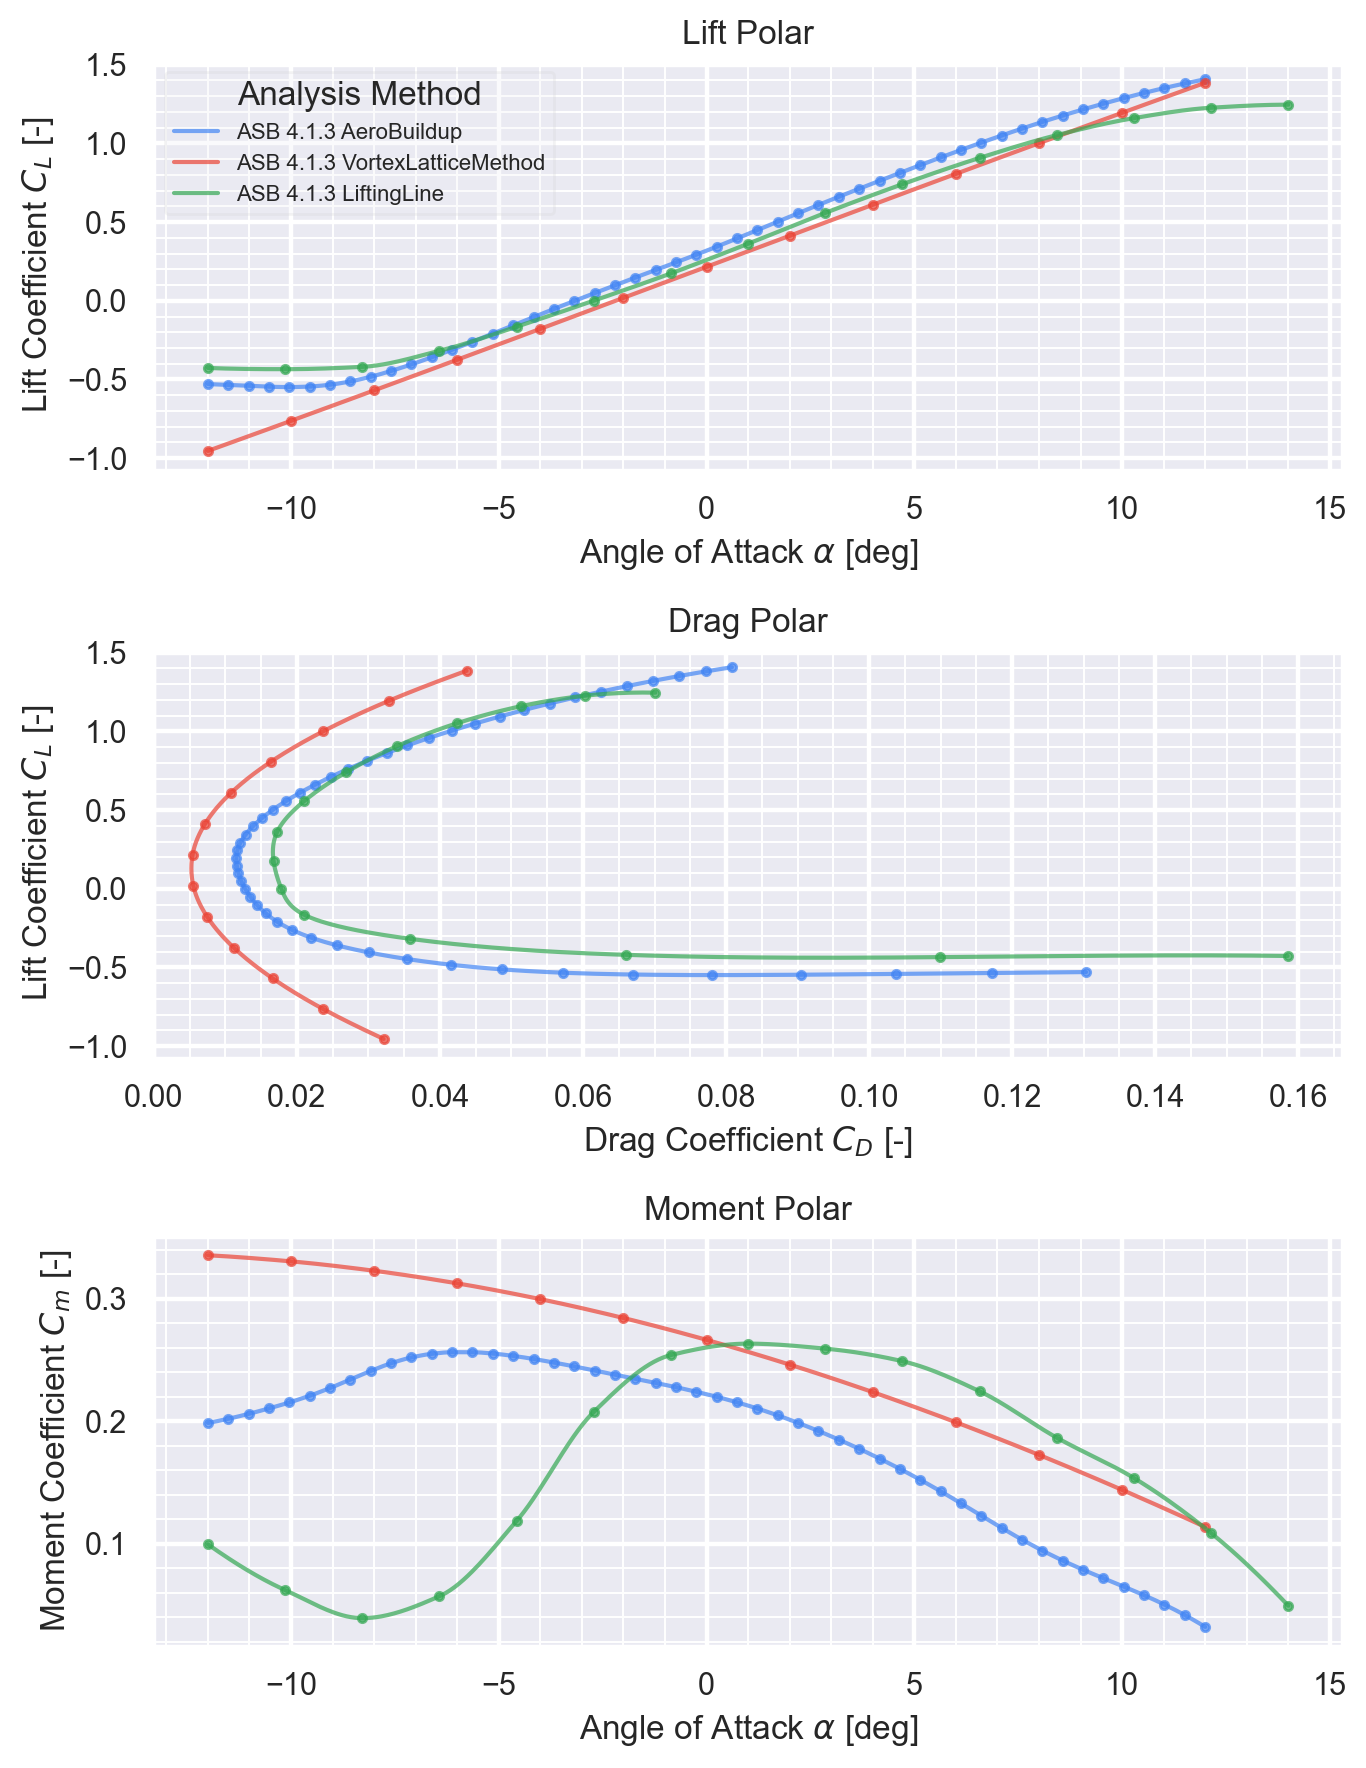

In [10]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(3, 1, figsize=(7, 9), dpi=200)

for name, aero in {
    f"ASB {asb.__version__} AeroBuildup"                       : aerobuildup_aero,
    f"ASB {asb.__version__} VortexLatticeMethod": vlm_aero,
    # f"ASB {asb.__version__} NonlinearLiftingLine"            : nlll_aero,
    f"ASB {asb.__version__} LiftingLine"            : ll_aero,
    # **name_data
}.items():
    plt.sca(ax[0])
    p.plot_smooth(
        aero["alpha"],
        aero["CL"],
        label=name,
        function_of="x",
        alpha=0.7,
    )

    plt.sca(ax[1])
    p.plot_smooth(
        aero["CD"],
        aero["CL"],
        label=name,
        alpha=0.7,
    )

    plt.sca(ax[2])
    p.plot_smooth(
        aero["alpha"],
        aero["Cm"],
        label=name,
        function_of="x",
        alpha=0.7,
    )

ax[0].set_title("Lift Polar")
ax[0].set_xlabel("Angle of Attack $\\alpha$ [deg]")
ax[0].set_ylabel("Lift Coefficient $C_L$ [-]")

ax[1].set_title("Drag Polar")
ax[1].set_xlabel("Drag Coefficient $C_D$ [-]")
ax[1].set_ylabel("Lift Coefficient $C_L$ [-]")
ax[1].set_xlim(left=0)

ax[2].set_title("Moment Polar")
ax[2].set_xlabel("Angle of Attack $\\alpha$ [deg]")
ax[2].set_ylabel("Moment Coefficient $C_m$ [-]")
# ax[2].set_ylim(top=0)  # Keep zero in view

ax[0].legend(
    title="Analysis Method",
    fontsize=8,
    framealpha=0.2,
)
p.show_plot(legend=False)